# **Pre-processing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import random
from random import choice
import numpy as np
import pandas as pd
from snownlp import SnowNLP
import torch
from torch.utils.data import Dataset,DataLoader
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
# Set the seed value all over the place to make this reproducible.
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

# **Create Bert dataset**

In [ ]:
def split_dataset(df):
    train_set, test_set = train_test_split(df,stratify=df['y'],
              test_size=0.2,random_state=42)
    # val_set, test_set = train_test_split(x,stratify=x['y'],
    #           test_size=0.5,random_state=43)
    return train_set, test_set

class creative_data(Dataset):
    def __init__(self, dataset):
        self.tokens, self.segments, self.masks, self.labels = [], [], [], []
        # self.tokenizer = BertTokenizer.from_pretrained("hfl/chinese-pert-base")
        self.tokenizer = BertTokenizer.from_pretrained("hfl/chinese-bert-wwm")
        texts, ys = dataset['text'],dataset['y']
        datas = [] 
        labels = [] 
        for x,y in zip(texts, ys):
          datas.append(x)
          labels.append(y)
        max_len = 126
        for cnt,(data,label) in enumerate(zip(datas,labels)):
            
            word = self.tokenizer.tokenize(data)            
            token = self.tokenizer.convert_tokens_to_ids(['[CLS]'] + word[:max_len] + ['[SEP]']) 
            while(len(token) < 128):
                token.append(0)          
            masks_tensors = torch.zeros(len(token),dtype=torch.long)
            masks_tensors = masks_tensors.masked_fill(torch.tensor(token) != 0, 1)
            
            self.tokens.append(token)
            self.segments.append([0 for i in range(len(token))])
            self.masks.append(masks_tensors)
            self.labels.append(label)
            print('\r'+'{}/{}'.format(cnt+1, len(datas)),end='')
            
        print(' done')
    def __getitem__(self,index):
        token = torch.tensor(self.tokens[index])
        segment = torch.tensor(self.segments[index]).long()
        mask = torch.tensor(self.masks[index])
        label = torch.tensor(self.labels[index])
        return token, segment, mask, label
    def __len__(self):
        return len(self.tokens)

# **Save and load model**

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
 
     """
     checkpoint_path: path to save checkpoint
     model: model that we want to load checkpoint parameters into       
     optimizer: optimizer we defined in previous training
 
     """
     # load check point
     checkpoint = torch.load(checkpoint_fpath)
     # initialize state_dict from checkpoint to model
     model.load_state_dict(checkpoint['state_dict'])
     # initialize optimizer from checkpoint to optimizer
     optimizer.load_state_dict(checkpoint['optimizer'])
     # initialize valid_loss_min from checkpoint to valid_loss_min
     valid_loss_min = checkpoint['valid_loss_min']
     # return model, optimizer, epoch value, min validation loss 
     return model, optimizer, checkpoint['epoch'], valid_loss_min

import shutil, sys  
def save_ckp(state, is_best, checkpoint_path, best_model_path):

    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

# **Define model**

In [ ]:
def train_model(set_epoch, set_labels, set_train_loader, set_test_loader, set_checkpoint_path, set_best_model_path, save=0):
  # model = BertForSequenceClassification.from_pretrained("hfl/chinese-pert-base", num_labels=set_labels).cuda()
  model = BertForSequenceClassification.from_pretrained("hfl/chinese-bert-wwm", num_labels=set_labels).cuda()

  total_steps = len(train_set) * set_epoch
  optimizer = torch.optim.Adam(model.parameters(), lr = 2e-7, eps = 1e-8)
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                        num_warmup_steps = 0,
                        num_training_steps = total_steps)
  checkpoint_path = set_checkpoint_path
  best_model_path = set_best_model_path
  history_train_acc = []
  history_train_loss = []
  history_val_acc = []
  history_val_loss = []
  valid_loss_min = np.Inf
  for epoch in range(1, set_epoch+1):
      # ========================================
      #        Train
      # ======================================== 

      train_predictions = []
      train_loss  = 0.0
      avg_train_loss = 0.0
      train_acc = 0.0
      train_total = 0  
      model.train()
      for cnt,data in enumerate(set_train_loader,1):
          
          token, segment, mask, label = [t.cuda() for t in data]
          model.zero_grad()
          # forward pass
          outputs = model(input_ids=token, 
                          token_type_ids=segment, 
                          attention_mask=mask, 
                          labels=label)
          
          # outputs = [(loss), logits, (hidden_states), (attentions)]
          loss = outputs[0]
          loss.backward()
          # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #梯度裁剪避免訓練loss nan的操作
          optimizer.step()
          scheduler.step()
          
          _, pred = torch.max(outputs[1].data, 1)
          train_total += label.size(0)
          train_acc += (pred==label).sum()

          train_loss += loss.item()
          avg_train_loss = train_loss/cnt
          train_predictions.extend(pred.view(-1).detach().cpu().numpy())
          print('\r[epoch {} {}/{}] train_loss: {:.4f}, train_acc: {:.4f}%'.format(epoch,
                                                    len(train_predictions),
                                                    len(train_set),
                                                    avg_train_loss,
                                                    train_acc /train_total * 100),end='',flush=True)
      # ========================================
      #        Validation
      # ========================================      
      val_predictions = []
      val_loss = 0.0
      avg_val_loss = 0.0
      val_acc = 0.0
      val_total = 0
      model.eval()
      for cnt1,data in enumerate(set_test_loader,1):
          
          token, segment, mask, label = [t.cuda() for t in data]
          with torch.no_grad(): 
              outputs = model(input_ids=token, 
                              token_type_ids=segment, 
                              attention_mask=mask, 
                              labels=label)
          
          _, pred = torch.max(outputs[1].data, 1)
          val_total += label.size(0)
          val_acc += (pred==label).sum()

          loss = outputs[0]
          val_loss += loss.item()
          avg_val_loss = val_loss/cnt1
          val_predictions.extend(pred.view(-1).detach().cpu().numpy())
          print('\r[epoch {} {}/{}] test_loss: {:.4f}, test_acc: {:.4f}%      '.format(epoch,
                                                    len(val_predictions),
                                                    len(test_set),
                                                    avg_val_loss,
                                                    val_acc /val_total * 100),end='')
      
      checkpoint = {
              'epoch': epoch,
              'valid_loss_min': val_loss / cnt1,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict()
              }
      if save!=0 and avg_val_loss <= 0.3:
        # save checkpoint
        save_ckp(checkpoint, False, checkpoint_path+f'{epoch}.pt', best_model_path+'.pt')
        print('\rSaving model                                                          ')
        ## TODO: save the model if validation loss has decreased
        if avg_val_loss+0.008 <= valid_loss_min :
          print('\rValidation loss decreased ({:.4f} --> {:.4f}).  Saving best model'.format(valid_loss_min,avg_val_loss))
          # save checkpoint as best model
          save_ckp(checkpoint, True, checkpoint_path+f'{epoch}.pt', best_model_path+'.pt')
          valid_loss_min = avg_val_loss
      print('\r------------------------------------------------------------------------')
      history_train_acc.extend((train_acc/train_total).view(-1).detach().cpu().numpy())
      history_train_loss.append(train_loss/cnt)
      history_val_acc.extend((val_acc/val_total).view(-1).detach().cpu().numpy())
      history_val_loss.append(val_loss/cnt1)
      
      print('[epoch {}] train_loss: {:.4f}, train_acc: {:.4f}%'.format(epoch, train_loss/cnt, train_acc/train_total * 100)
          +'——val_loss: {:.4f}, val_acc: {:.4f}%'.format(val_loss/cnt1, val_acc/val_total * 100))
      print('------------------------------------------------------------------------')
  return model, history_train_acc,  history_train_loss, history_val_acc ,history_val_loss

# **Build evaluation standard**

In [ ]:
def score(true, pred):
        print('Val Result:')
        print(f"Accuracy Score: {accuracy_score(true, pred)*100:.2f}%")
        print(f"Precision Score: {precision_score(true, pred)*100:.2f}%")
        print(f"Recall Score: {recall_score(true, pred)*100:.2f}%")
        print(f"F1 score: {f1_score(true, pred)*100:.2f}%")
        print(f"AUC score: {roc_auc_score(true, pred)*100:.2f}%")
        print(f"Confusion Matrix:\n {confusion_matrix(true, pred)}")

def evaldata(model, pre_data, org_data):
  model.eval()
  predictions = []
  true_labels = []
  val_loss = 0.0
  val_acc = 0.0
  val_total = 0
  model.eval()
  for cnt,data in enumerate(pre_data,1):
      
    token, segment, mask, val_label = [t.cuda() for t in data]
    with torch.no_grad(): 
        outputs = model(input_ids=token, 
                        token_type_ids=segment, 
                        attention_mask=mask,
                        labels=val_label)

    _, pred = torch.max(outputs[1].data, 1)
    val_total += val_label.size(0)
    val_acc += (pred==val_label).sum()

    loss = outputs[0]
    val_loss += loss.item()
    true_labels.extend(val_label.view(-1).detach().cpu().numpy())
    predictions.extend(pred.view(-1).detach().cpu().numpy())
    print('\r','[{}/{}]val_loss: {:.4f}, val_acc: {:.4f}%'.format(len(predictions),
                                        len(org_data),
                                        val_loss/cnt,
                                        val_acc/val_total * 100),end='\r')
  
  print('[{}/{}]val_loss: {:.4f}, val_acc: {:.4f}%'.format(len(predictions),
                                    len(org_data),
                                    val_loss/cnt, 
                                    val_acc/val_total * 100))
  score(true_labels, predictions) 
  print('------------------------------------------------------------------------')

# **Example**

In [ ]:
df = pd.read_csv('/training_data.csv',encoding='utf-8-sig',na_values='None')
train_set, test_set = split_dataset(df1)

batch_size = 16
train_loader = DataLoader(creative_data(train_set), batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(creative_data(test_set), batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
checkpoint_path = '/your_path/current_checkpoint.pt'
best_model_path = '/your_path/best_model.pt'
model, history_train_acc, history_train_loss, history_val_acc, history_val_loss = train_model(15,
                                                                                              2,
                                                                                              train_loader,
                                                                                              test_loader,
                                                                                              checkpoint_path,
                                                                                              best_model_path,
                                                                                              0)

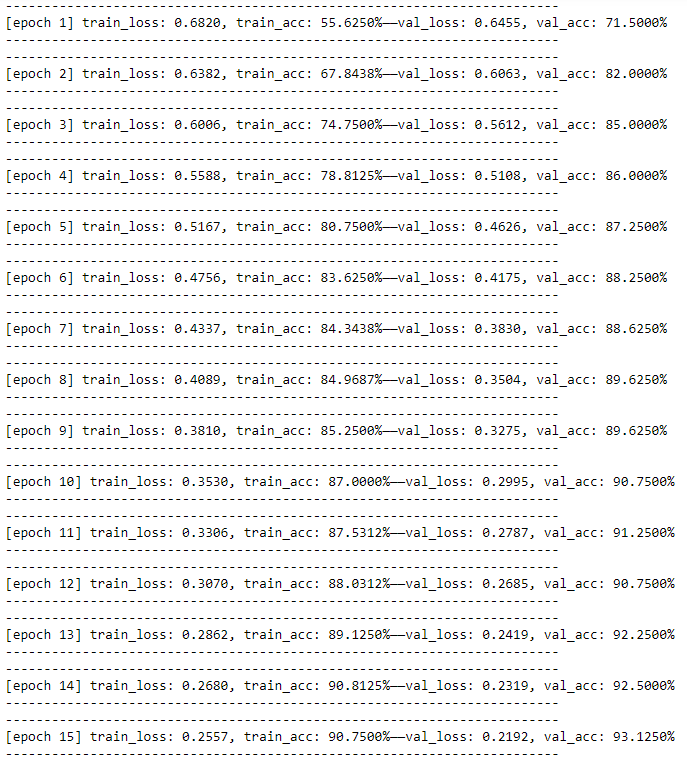

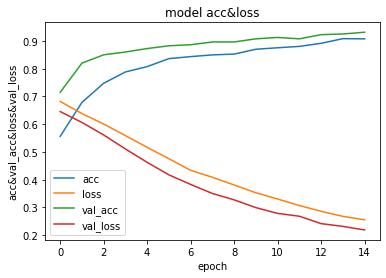

In [ ]:
import matplotlib.pyplot as plt
  
plt.plot(history_train_acc)
plt.plot(history_train_loss)
plt.plot(history_val_acc)
plt.plot(history_val_loss)
plt.title('model acc&loss')
plt.ylabel('acc&val_acc&loss&val_loss')
plt.xlabel('epoch')
plt.legend(['acc','loss','val_acc','val_loss'],loc='best')
plt.show()

In [ ]:
df_eva = pd.read_csv('/yourData.csv',encoding='utf-8-sig')
df_eva = df_eva.sample(frac=1,random_state=42).reset_index(drop=True)
df_eva_loader = DataLoader(creative_data(df4), batch_size=batch_size, shuffle=True, num_workers=0)
evaldata(model, df_eva_loader, df_eva)

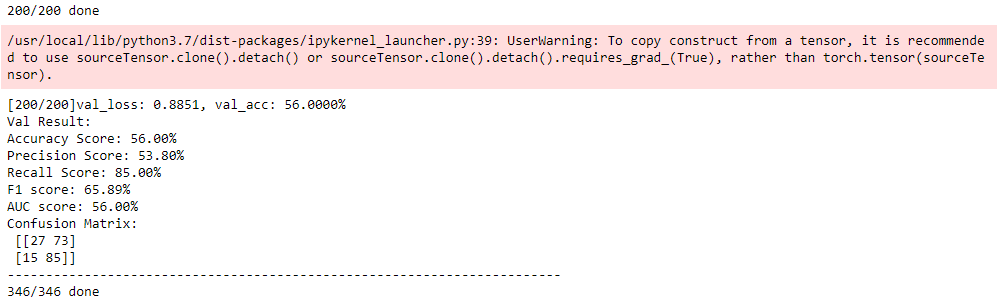

# **Classify data**

In [ ]:
def scoredata(model, data):
  tokenizer = BertTokenizer.from_pretrained("hfl/chinese-bert-wwm")
  predictions = []
  for i in data:
    encoded_review = tokenizer.encode_plus(
      i,
      max_length=128,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      # truncation=True
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    
    _, pred = torch.max(output[0].data, dim=1)
    predictions.extend(pred.view(-1).detach().cpu().numpy())
  print('done')
  return predictions

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model_path = '/your_path/best_model.pt'
model = BertForSequenceClassification.from_pretrained("hfl/chinese-bert-wwm", num_labels=2).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-7, eps = 1e-8)

model, optimizer, checkpoint, valid_loss_min = load_ckp(best_model_path, model, optimizer)

In [ ]:
df = pd.read_csv('/your_data.csv',encoding='utf-8-sig')

ra =df.r_content.values.tolist()
wa = scoredata(model, ra)

score=pd.DataFrame(wa,columns=['score'])
new_df=pd.concat([df,score],axis=1)

new_df.to_csv('/your_data.csv', index=False)

# **Training data sample**

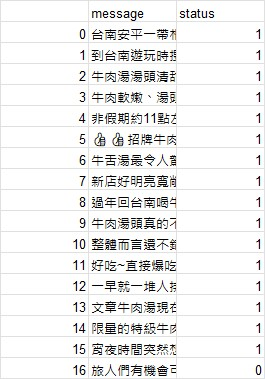

# **Before classified**

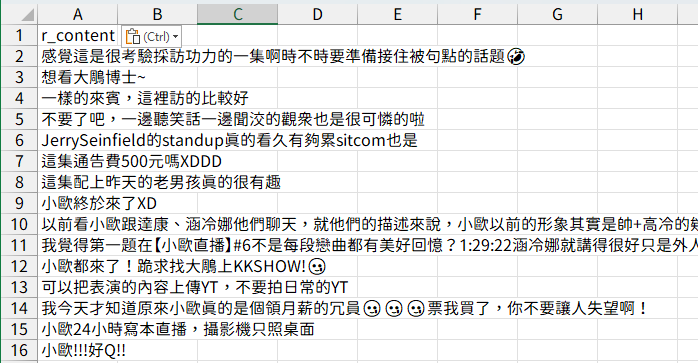

# **After classified**

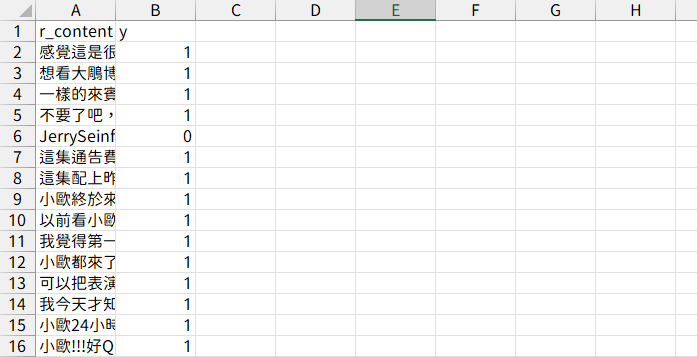